# Scrapbook

This notebook is used for development, its content can change at any time.

In [43]:
import timeatlas as ta
import pandas as pd
from darts import TimeSeries as DTS
import numpy as np

In [134]:
s = pd.read_csv("../data/bbdata/2902.csv")
s = pd.DataFrame(data=s["value"].values, index=pd.to_datetime(s["timestamp"]).values)
s.index = s.index.round("S")

In [135]:
ts = ta.TimeSeries(s)

In [136]:
s = s.asfreq("S", method="backfill")
ts_filled = ta.TimeSeries(s)

In [137]:
ts.empty()

                    values
2018-02-01 00:13:10   None
2018-02-01 00:28:10   None
2018-02-01 00:43:10   None
2018-02-01 00:58:10   None
2018-02-01 01:13:10   None
...                    ...
2018-02-01 22:58:05   None
2018-02-01 23:13:04   None
2018-02-01 23:28:04   None
2018-02-01 23:43:04   None
2018-02-01 23:58:04   None

[95 rows x 1 columns]

/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


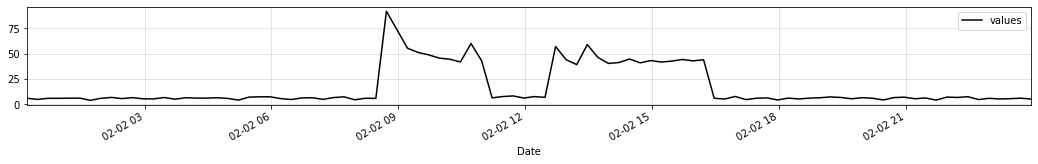

In [138]:
ts.plot()

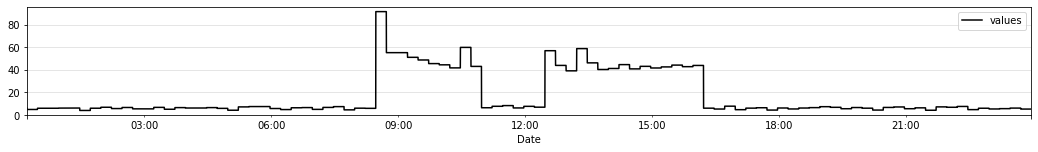

In [139]:
ts_filled.plot()

In [140]:
ts.describe()

,values
count,95.000000
mean,16.754200
std,19.096193
min,4.095000
25%,5.959500
50%,6.620000
75%,23.790001
max,91.604996


In [141]:
ts.min()

values    4.095
dtype: float64

In [142]:
ts.max()

values    91.604996
dtype: float64

In [143]:
ts.boundaries()

(Timestamp('2018-02-01 00:13:10'), Timestamp('2018-02-01 23:58:04'))

In [144]:
ts.duration()

Timedelta('0 days 23:44:54')

/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


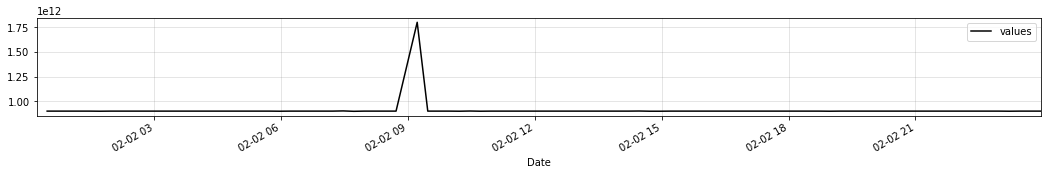

In [146]:
ts.resolution().plot()

/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


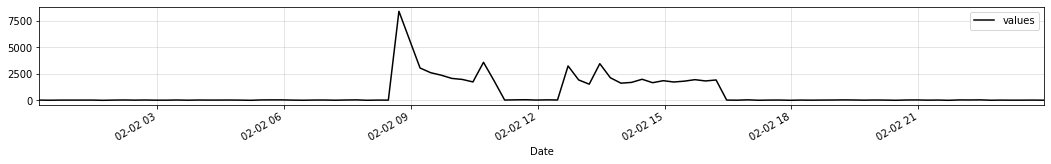

In [147]:
ts.apply(lambda x : x**2).plot()

/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


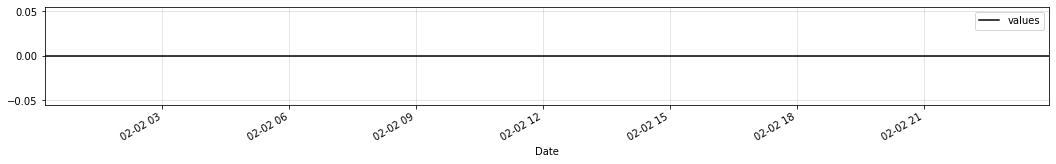

In [149]:
ts.apply(lambda x,y: x-y, ts).plot()

In [150]:
ts = ta.TimeSeries.create("01-2020", "02-2020", "H")
ts = ts.fill(np.random.randint(0,1000,len(ts)))
ts

                     values
2020-01-01 00:00:00     389
2020-01-01 01:00:00     307
2020-01-01 02:00:00     203
2020-01-01 03:00:00     625
2020-01-01 04:00:00     950
...                     ...
2020-01-31 20:00:00     501
2020-01-31 21:00:00     667
2020-01-31 22:00:00     304
2020-01-31 23:00:00     490
2020-02-01 00:00:00     227

[745 rows x 1 columns]

In [152]:
test = ts.to_darts()

In [157]:
ts.series["values"].equals(test.pd_series())

True

## Define a Metadata object

In [ ]:
from timeatlas import Metadata, types

# You can use some typed metadata object
my_unit = types.Unit("power", "W", "float")
my_sensor = types.Sensor(2902, "HB/floor2/22-23C/Prises_Power_Tot")

# Or use Python dictionaries
my_location = {
    "building" : "Blue Factory",
    "floor" : "12",
    "room"  : "22C"
}
my_coordinates = {
    "lat" : 46.796611,
    "lon" : 7.147563
}
my_dict = {
    "unit": my_unit,
    "sensor": my_sensor,
    "location": my_location,
    "coordinates": my_coordinates
}

# Create the Metadata object
my_meta = Metadata(my_dict)


## Define a TimeSeries with Metadata

In [ ]:
ts_meta = TimeSeries(s, my_meta)
ts_meta

## Make Predictions

Some definitions:

- `time series` : self-explanatory, i.e. the TimeSeries object
- `horizon` : the duration to predict after the last value of the time series
- `frequency`: the number of values per unit of time. Usually, the frequency is given in Pandas offset aliases (https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

```
                                horizon
   |-------------------------|- - - - - -|
                             |||||||||||||
           time series         frequency

```

In [ ]:
from timeatlas import models

In [ ]:
m1 = models.Prophet()
m1.fit(ts_meta)
pts1 = m1.predict(ts_meta)
pts2 = m1.predict("24 hours")

In [ ]:
m2 = models.LinearRegression()
m2.fit(ts_meta)
pts3 = m2.predict(ts_meta)
pts4 = m2.predict("14 days")

In [ ]:
from timeatlas import plots

plots.prediction(ts_meta, pts1)

## Detect Anomalies


In [ ]:
from timeatlas import detectors, metrics

In [ ]:
ts.apply(lambda x: x+1).series.head()

In [ ]:
# Create the base of the detector. 
# i.e. this detector is based on this model and compute this error
d = detectors.Surprise(m1, metrics.relative_error)

# Set the alerts
d.alerts("quantile", [0.65, 0.8, 0.85, 0.95])\

# Fit the detector with a specific Time Series
d.fit(ts_meta)

In [ ]:
# Detect anomalies with the fitted detector
a = d.detect(ts2)

In [ ]:
a.plot()

In [ ]:
d.truth.plot()
d.prediction.plot()

## Scalers

In [ ]:
from timeatlas.processing import scalers

In [ ]:
ts_meta.plot()

In [ ]:
y = scalers.minmax(ts_meta)

In [ ]:
y.plot()